# Statistical analysis of gene expression in different tissue cultures

In [1]:
import pandas as pd
import joypy
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load data
df = pd.read_csv("data_sorted.csv")
df_long = df.melt(var_name='Culture', value_name='Value')   # for visualization
df

,ALL,PML,MYE,LYM,CML
0,7.18350,7.11836,7.55379,7.37580,7.16879
1,7.19263,7.23998,7.60075,7.42104,7.11564
2,7.26570,7.26544,7.49090,7.30891,7.12803


First thing first, how do the data look like?

## Visualization

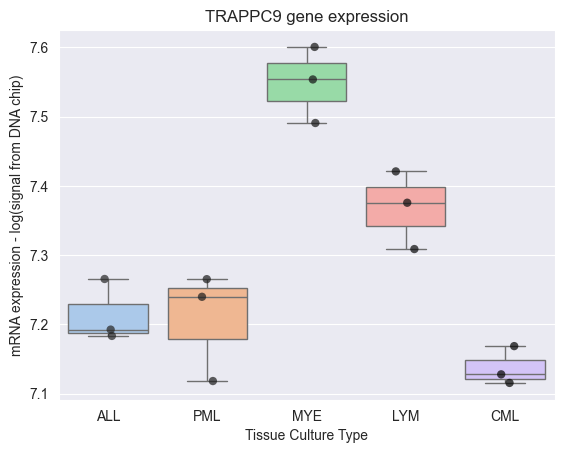

In [3]:
# Boxplots for each group
ax = sns.boxplot(x='Culture', y='Value', data=df_long, palette="pastel", showfliers=False, hue='Culture')

# Stripplot (jitter) for every datapoint
sns.stripplot(x='Culture', y='Value', data=df_long, palette='dark:black', size=6, alpha=0.7, hue='Culture')

plt.title('TRAPPC9 gene expression')
plt.ylabel('mRNA expression - log(signal from DNA chip)')
plt.xlabel('Tissue Culture Type')

plt.savefig("plots/boxplot_culture_comparison.png")
plt.show()

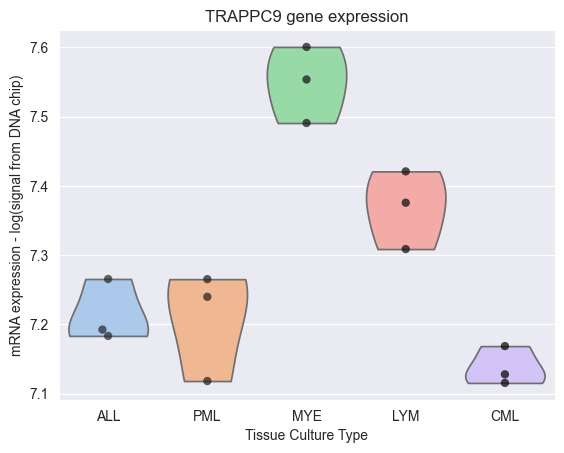

In [4]:
# Violin plot
sns.violinplot(
    x=df_long['Culture'], y=df_long['Value'], data=df_long, inner=None, palette="pastel", cut=0, hue=df_long['Culture']
)

sns.swarmplot(
    x=df_long['Culture'], y=df_long['Value'], data=df_long, palette='dark:black', size=6, alpha=0.7, hue=df_long['Culture']
)

plt.title('TRAPPC9 gene expression')
plt.ylabel('mRNA expression - log(signal from DNA chip)')
plt.xlabel('Tissue Culture Type')

plt.savefig("plots/violinplot_culture_comparison.png")
plt.show()

Hmmm... Do you think the means are different?

Before we try ANOVA, we need to perform Levene's test in order to check the homogeneity of variances.

In [ ]:
# Prepare data
groups = []
for col in df.columns:
    groups.append(df[col])

## Levene's test

- H0: sigma(ALL) = ... = sigma(CML)
- H1: at least one of these is not equal
- alpha = 0.05

In [9]:
# Levene's test
levene_stat, p_value = stats.levene(*groups, center='mean')
print(f"Statistics = {levene_stat:.3f}\np-values = {p_value:.7f}")

Statistics = 1.031
p-values = 0.4376407


Here we see that p-value > alpha. Uff, we fail to reject H0. We can proceed with the classic one-way ANOVA.

### Summary of assumptions:
- independent groups
- "approximately" normal distribution
- homodesceidasticity of variances

## ANOVA

- H0: mi(ALL) = mi(PML) = mi(MYE) = mi(LYM) = mi(CML)
- H1: at least one of these is not equal

- alpha = 0.05


And we compute the ANOVA:

In [6]:
# ANOVA
f_score, p_value = stats.f_oneway(*groups)
print(f"Statistics = {f_score:.3f}\np-values = {p_value:.7f}")

Statistics = 26.796
p-values = 0.0000252


We can see nicely significant p-value (quite smaller than 0.05).

Therefore, we REJECT H0.

And now here is our next question: Which group differs from the others?

Let's perform a post-hoc test - Tukey HSD.

## Tukey's HSD

In [7]:
# Prepare for post-hoc test into long format
df_long = df.melt(var_name='Culture', value_name='Value')
df_long

,Culture,Value
0,ALL,7.18350
1,ALL,7.19263
2,ALL,7.26570
3,PML,7.11836
4,PML,7.23998
5,PML,7.26544
6,MYE,7.55379
7,MYE,7.60075
8,MYE,7.49090
9,LYM,7.37580


In [8]:
# Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_long['Value'], groups=df_long['Culture'], alpha=0.05)

print("--- Tukey HSD Post-hoc test ---")
print(tukey)

--- Tukey HSD Post-hoc test ---
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   ALL    CML  -0.0765  0.476 -0.2246  0.0717  False
   ALL    LYM   0.1546   0.04  0.0065  0.3028   True
   ALL    MYE   0.3345 0.0002  0.1864  0.4827   True
   ALL    PML   -0.006 0.9999 -0.1542  0.1422  False
   CML    LYM   0.2311 0.0031  0.0829  0.3793   True
   CML    MYE    0.411    0.0  0.2628  0.5592   True
   CML    PML   0.0704 0.5484 -0.0777  0.2186  False
   LYM    MYE   0.1799 0.0168  0.0317  0.3281   True
   LYM    PML  -0.1607 0.0325 -0.3088 -0.0125   True
   MYE    PML  -0.3406 0.0001 -0.4887 -0.1924   True
----------------------------------------------------


These combinations represent cultures that should not have the same distribution (of mRNA concentration):
- ALL vs LYM
- ALL vs MYE
- CML vs LYM
- CML vs MYE
- LYM vs MYE

## Conclusion

We can conclude, that expression level of the gene TRAPPC9 differs between various tissue cultures.